# 1. Introduction

In this notebook we build a Naive Bayes classifier model based on Online Shoppers Purchasing Intention Dataset [1]. 

The notebook first introduces the general family of algorithms associated with Bayesian Classification methods, followed by the selected algorithms and the necessary preprocessing steps required to run them. 

This is followed by hyperparameter tuning of the models via a cross-validation scheme, and an exploration of the feature importance of the dataset. 

Lastly, techniques to deal with the imbalanced nature of the dataset will be explored: Firstly, through the use of threshold moving which will be visualised using the AUC (Area under Curve) ROC (Receiver Operating Characteristic) and PR (Precision Recall) curves, and secondly, through resampling techniques.  

# 2. Bayesian Classification Methods

<div>
<img src="BayesianLearning.png" alt="drawing" width="600"/>
</div>
<center>Figure 1: Illustration of some of the different families of learning methods [2]<center>


Naive Bayes Classifiers can be described as a family of supervised learning methods (Fig1) which are based on Bayes' theorem with strong assumption of independence between the features. These classification methods aim to predict the class label of a categorical target variable.

Bayes Theorem is an equation that describes the relationship of conditional probabilities of statistical quantities [2]. In simple terms, the equation aims to find out the probability of a label ($C_k$) given a number of observed features ($X$), and can be expressed mathematically as: <br> <br>
&emsp;<center> $P(C_k | X)= \large\frac{P(X | C_k)P(C_k)}{P(X)}$ <center>

where
* $k$ distinguishes between the classes
* P($C_k | X$) is the posterior probability of the label ($C_k$) given the predictor ($X$)
* P($C_k$) is the prior probability of the label 
* P($X | C_k$) is the likelihood, which the the probability of the predictor given the class label
* P($X$) is the prior probability of the predictor $X$

Using the naive assumption of feature independence, $P(x_i|C_k)$ can be reduced from $P(x_i|C_k) = P(x_i|C_k, x_1, ..., x_i-1, x_i+1, ..., x_n)$ for all $i$ to $P(X|C_k) = P(x_1|C_k)* P(x_2|C_k)*....* P(x_n|C_k)$

and the resulting equation for classification becomes 

<center> $P(C_k|X) = \large\frac{\prod_{i=1}^nP(x_i | C_k) * P(C_k)}{P(X)}$ </center>

and the class label predicted by the model is the one that has the highest probability. For instance, if there are two class labels 'True' and 'False', and if $P(True|X) = 0.7$ and $P(False|X) = 0.3$ then the predicted class label would be 'True'.

The different classifiers mainly differ according to the assumptions they make regarding the distribution of $P(x_i|C_k)$. The most common classifiers (and their assumptions) are:
* <b>Gaussian Naive Bayes</b> - Assumes data from each feature follows a Gaussian Distribution, used when data is continuous (Example - Age) 
* <b>Bernoulli Naive Bayes</b> - Assumes data from each feature follows a Bernoulli Distribution, used for discrete data where features are binary/boolean (Example - Feature 'Is Male' is True/False)
* <b>Multinomial Naive Bayes</b> - Features are assumed to be generated from a multinomial distribution (which describes probability of observing counts among a number of categories) (Example - Text Classification)
* <b>Complement Naive Bayes</b> - Adaptation of the Multinomial Naive Bayes, designed to work with imbalanced datasets (instead of calculating probability of an item belonging to a particular class, the probability of the item belonging to all other classes is used instead, and the smallest value is selected)
* <b>Categorical Naive Bayes</b> - Generalization of the Bernoulli distribution, features follow a categorical distribution where there are more than two possible outcomes (Example - Outcome of a dice roll)

From the earlier section in which the characteristics of the dataset was explored, it can be seen that the features are either numerical/continuous (4 features) or categorical (5 Features). Therefore, no one model is perfectly suited for the dataset. To overcome this problem, we can take two possible approaches, and will be covered in greater detail below

* The first approach is to categorise the numerical features, then use the Categorical Naive Bayes classifier. 
* The second approach (Mixed Naive Bayes) is to independently fit a Gaussian NB Classifier and Categorical NB Classifier for the respective numerical and categorical features, and then transform the dataset by setting the class assignment probabilities as new features (this works due to the Naive assumption of independence between features) . Following which, a Gaussian NB classifier will be refit on these features. 

# 3. Preprocessing Data

Class Names: indicating a revenue when True else False - ['False', 'True'] <br>
Feature Names: ['ProductRelated_Duration', 'ProductRelatedAve', 'BounceRates', 'ExitRates', 'SpecialDay', 'Month', 'Region', 'VisitorType', 'Weekend']

In this section, we preprocess the dataset for the approaches explained above. 

The variable **data_frame_os** represents the dataset in which the categorical variables have been factorized whilst the numerical variables are left untouched, and are intended for use by the MixedNB model. 

The variable **data_frame_os_cat** represents the transformed dataset in which all variables have been set to categorical

In [9]:
# import necessary modules for this notebook
from main import *

In [1]:
data_frame_os = read_data_return_frame("online_shoppers_intention.csv")
preprocess_df(data_frame_os) # function preprocess_df factorizes the categorical variables
data_frame_os # return factorized dataset


,ProductRelated_Duration,ProductRelatedAve,BounceRates,ExitRates,SpecialDay,Month,Region,VisitorType,Weekend,Revenue
0,0.000000,0.000000,0.200000,0.200000,0.0,0,1,0,0,False
1,64.000000,32.000000,0.000000,0.100000,0.0,0,1,0,0,False
2,0.000000,0.000000,0.200000,0.200000,0.0,0,9,0,0,False
3,2.666667,1.333333,0.050000,0.140000,0.0,0,2,0,0,False
4,627.500000,62.750000,0.020000,0.050000,0.0,0,1,0,1,False
...,...,...,...,...,...,...,...,...,...,...
12325,1783.791667,33.656447,0.007143,0.029031,0.0,9,1,0,1,False
12326,465.750000,93.150000,0.000000,0.021333,0.0,7,1,0,1,False
12327,184.250000,30.708333,0.083333,0.086667,0.0,7,1,0,1,False
12328,346.000000,23.066667,0.000000,0.021053,0.0,7,3,0,0,False


In [2]:
data_frame_os_cat = data_frame_os.copy()
convert_num_to_cat(data_frame_os_cat) # function bins the continuous variables and label encodes it
data_frame_os_cat

,ProductRelated_Duration,ProductRelatedAve,BounceRates,ExitRates,SpecialDay,Month,Region,VisitorType,Weekend,Revenue
0,0,0,2,4,0,0,1,0,0,False
1,0,2,0,4,0,0,1,0,0,False
2,0,0,2,4,0,0,9,0,0,False
3,0,0,2,4,0,0,2,0,0,False
4,2,4,1,3,0,0,1,0,1,False
...,...,...,...,...,...,...,...,...,...,...
12325,4,2,0,2,0,9,1,0,1,False
12326,2,4,0,2,0,7,1,0,1,False
12327,1,2,2,4,0,7,1,0,1,False
12328,1,1,0,2,0,7,3,0,0,False


# 4. Brief Exploration of Data

Although covered in the earlier section, the numerical variables are attached here for convenient reference. Additionally, the processed categorical dataset is also briefly explored. It is important to note that the dataset is highly unbalanced, where the 'False' class outnumbers the 'True' class by a ratio of about 5:1 (more on that later).

Lastly, the Variance Inflation Factor (VIF) results are attached here again. VIF can be computed as
$\large\frac{1}{1-R^2}$, and measures the collinearity of the variables, and high values are likely to reduce the effectiveness of this particular family of classifiers due to violation of the naive assumption of feature independence. Generally, as a rule of thumb, VIF > 5 indicates high multicollinearity.

In [137]:
data_frame_os.iloc[:,:4].describe() # Description of numerical features in data_frame_os

,ProductRelated_Duration,ProductRelatedAve,BounceRates,ExitRates
count,12330.000000,12330.000000,12330.000000,12330.000000
mean,1194.746220,37.633690,0.022191,0.043073
std,1913.669288,44.767916,0.048488,0.048597
min,0.000000,0.000000,0.000000,0.000000
25%,184.137500,17.613281,0.000000,0.014286
50%,598.936905,28.878189,0.003112,0.025156
75%,1464.157213,45.084444,0.016813,0.050000
max,63973.522230,1411.000000,0.200000,0.200000


ProductRelated_Duration
[0, 2, 1, 3, 4]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
Counts by ProductRelated_Duration
0    2468
2    2467
4    2466
3    2465
1    2464
Name: ProductRelated_Duration, dtype: int64
ProductRelatedAve
[0, 2, 4, 1, 3]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
Counts by ProductRelatedAve
0    2467
4    2466
3    2466
2    2466
1    2465
Name: ProductRelatedAve, dtype: int64
BounceRates
[2, 0, 1]
Categories (3, int64): [0 < 1 < 2]
Counts by BounceRates
0    7415
2    2459
1    2456
Name: BounceRates, dtype: int64
ExitRates
[4, 3, 2, 1, 0]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
Counts by ExitRates
3    2472
1    2471
0    2466
2    2461
4    2460
Name: ExitRates, dtype: int64
SpecialDay
[0 2 4 5 1 3]
Counts by SpecialDay
0    11079
3      351
4      325
2      243
1      178
5      154
Name: SpecialDay, dtype: int64
Month
[0 1 2 3 4 5 6 7 8 9]
Counts by Month
2    3364
7    2998
1    1907
9    1727
3     549
8     448
6     433
5     432
4     288
0     184

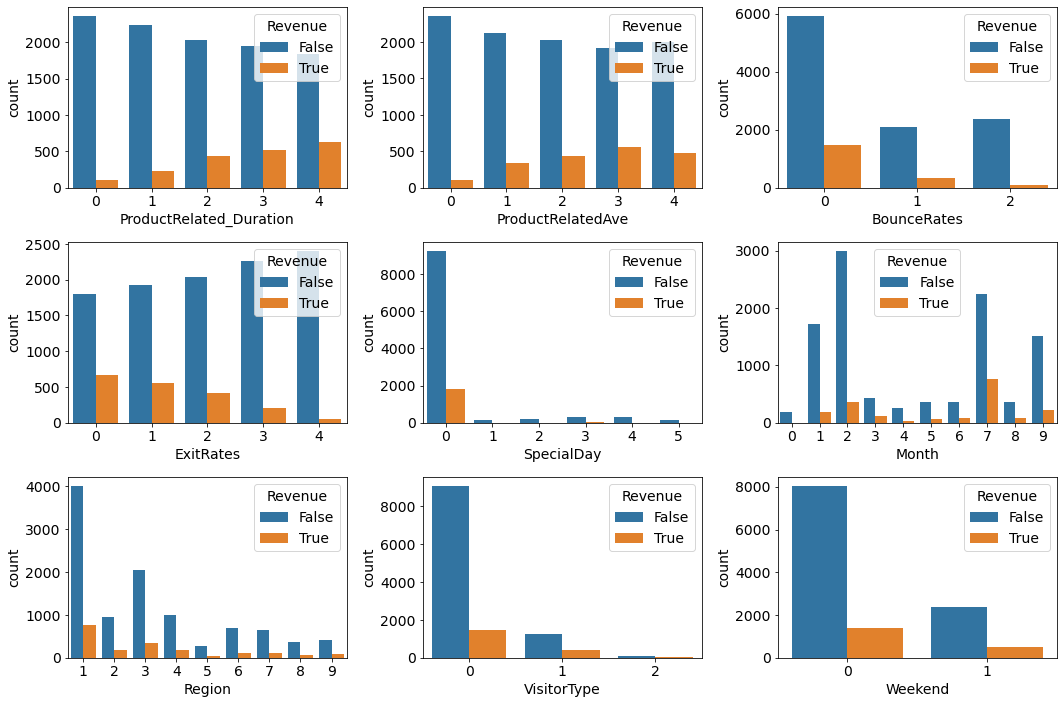

In [141]:
# Description of variables of processed categorical dataset data_frame_os_cat 
for indx, var in enumerate(data_frame_os.columns.tolist()):
    print(var)
    print(data_frame_os_cat[var].unique())
    print('Counts by', var)
    print(data_frame_os_cat[var].value_counts())
    
def count_plot(df, columns):
    plt.figure(figsize=(15, 10))
    for indx, var  in enumerate(columns):
        plt.subplot(3, 3, indx+1)
        g = sns.countplot(df[var], hue= df['Revenue'])
    plt.tight_layout()

features = data_frame_os.columns.tolist()
features.remove('Revenue')
import warnings
warnings.filterwarnings('ignore')
count_plot(data_frame_os_cat, features) # Plot the categorical features

In [147]:
# Value of 1 means no correlation, values >5 usually viewed as moderate to high. 
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_minus_rev = data_frame_os_cat[features]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(df_minus_rev.values, i) for i in range(len(features))]
vif["Features"] = features
vif 

,VIF,Features
0,5.646041,ProductRelated_Duration
1,5.335278,ProductRelatedAve
2,2.716612,BounceRates
3,4.513347,ExitRates
4,1.197827,SpecialDay
5,3.335315,Month
6,2.444946,Region
7,1.276248,VisitorType
8,1.271668,Weekend


As seen, generally the features do not have high VIF value, and hence should not violate the naive assumption of the classifiers too severely. ProductRelated_Duration and ProductRelatedAve might be problematic features. To reduce the issue of multicollinearity, we can drop one of the correlated features (ProductRelatedAve), which should help bring down the multicollinearity

In [149]:
features.remove('ProductRelated_Duration')
df_m_rev_prod = df_minus_rev.drop(['ProductRelated_Duration'], axis = 1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(df_m_rev_prod.values, i) for i in range(len(features))]
vif["Features"] = features
vif 

,VIF,Features
0,2.328944,ProductRelatedAve
1,2.681161,BounceRates
2,4.170462,ExitRates
3,1.167971,SpecialDay
4,2.890672,Month
5,2.387033,Region
6,1.231762,VisitorType
7,1.264769,Weekend


Remove the 'ProductRelatedDuration' variable from both datasets

In [153]:
data_frame_os_2 = data_frame_os.drop(['ProductRelated_Duration'], axis = 1)
data_frame_os_cat_2 = data_frame_os_cat.drop(['ProductRelated_Duration'], axis = 1)

# 5. Categorical Naive Bayes Classifier

For the Categorical Naive Bayes Classifier, for each feature $i$ of $X$ (training set), a categorical distribution is estimated conditioned on the class $y$

the probability of category $k$ in feature $i$ given class $c$ can be estimated as <br>
<center> $P(x_i = t | y = k; a) = \large\frac{N_{tik} + a}{N_k + an_i}$ </center>

where 

- $N_{tik}$ refers to the number of times category t appears in the sample $x_i$ belonging to the class $k_i$
- $N_k$ refers to the total number of samples with class $k$
- $a$ is a smoothing parameter (Laplace/Lidstone) which helps to handle the zero frequency problem. This problem occurs when the model encounters new features not seen in the training set (causing likelihood for that feature to be calculated as 0). Subsequently, without the parameter, the posterior probability would also return a value of 0 as all likelihoods are multiplied. The larger the $a$ value, the likelihood probability moves towards uniform distribution (0.5)
- $n_i$ refers to the number of categories of feature $i$

To implement the classifier, the Categorical Naive Bayes algorithm from the scikit learn module was used(sklearn.naive_bayes.CategoricalNB), and for this classifier, the only hyperparameter that requires tuning is $a$.

Data was first split into a set for training (75%) and testing (25%) (stratified to ensure they both have the same class ratio). Then, a cross-validated grid-search method (GridSearchCV) over a manually set parameter grid [0.1,0.5, 1.0, 5, 10, 100] was conducted to tune the hyperparameters and evaluate the models. The cross validation  split the data into $k$ (typically 5 or 10 is generally optimal, but due to the smaller size of the dataset, 5 was selected to maintain representativeness of the samples) folds, where the data was fitted using $k-1$ folds and validated with the remaining fold for each parameter set. The hyperparameter setting returning the highest average f1 score (covered below) was then selected as the model for use on the test set. 

The performance metric used is 'f1', which is a weighted average of the precision and recall of the model. The formulas for precision, recall and F1 score are: 

<center> <br>Precision = True Positives / (True Positives + False Positives)<br> 	
Recall = True Positives / (True Positives + False Negatives) <br> F1 = 2 * (precision * recall) / (precision + recall) </center>

The reason for choosing F1 score over the more commonly used 'Accuracy' is because of the class imbalance (high number of majority class 'False' examples), as the F1 score does not make use of the 'True Negatives' as with the case of 'Accuracy', but rather focuses on the ability of the model to predict the minority class correctly. 

In [4]:
# Function to split the dataset into features and classes and factorises the class labels
def xy_split(df):
    #return all column except last one for arttributes
    x = df.iloc[:,0: -1:1].values

    #return last column for label revenue true(1) / false(0)
    y = df.iloc[:, -1]
    y,class_names = pd.factorize(y)
    class_names = [str(x) for x in class_names]

    #get feature names
    feature_names = list(df.columns)[:-1]
        
    return x, y, class_names, feature_names

In [5]:
# Function to split the dataset into training/test sets and tunes hyperparameters through cross validation 
def train_test_classifier(x, y, test_size=0.25, classifier= "Categorical"):
    
    # split into train/test sets with same class ratio
    x_train, x_test, y_train, y_test = \
        model_selection.train_test_split(x, y, test_size=test_size, stratify=y, random_state=42)
    
    param_grid = [{'alpha': [0.1,0.5, 1.0, 5, 10, 100]}]
     
    if classifier == 'Gaussian':      
        classifier = GaussianNB()
        classifier.fit(x_train, y_train)
        print('Classes: ', classifier.classes_)
        print('Class Priors: ',classifier.class_prior_)        

    elif classifier == "Categorical":
        classifier = CategoricalNB()   
        grid_search = GridSearchCV(classifier, param_grid, cv=5, verbose=2, scoring = 'f1')
        grid_search.fit(x_train, y_train)   
        classifier = grid_search.best_estimator_
        print('-------------------------')
        print('Best Hyperparameter Setting (by f1 score):', classifier)
        classifier.fit(x_train, y_train)
        print('Classes: ', classifier.classes_)
        print('Class Log Priors: ',classifier.class_log_prior_)
        
    return x_train, x_test, y_train, y_test, classifier

In [6]:
# Function to use the selected classifier to predict the class values of a given set
def prediction(classifier, x):
    y_pred = classifier.predict(x)
    return y_pred

In [22]:
# Function to return the performance report of the model. The F1 score and Confusion Matrix are returned
def f1_cm_report(y, y_pred, class_names=[]):

    f1score = sklearn.metrics.f1_score(y, y_pred)
    print("F1 Score: {:.2f}".format(f1score))

    cm = sklearn.metrics.confusion_matrix(y, y_pred)
    print(sklearn.metrics.classification_report(y, y_pred, target_names=class_names))
    
    print('Confusion Matrix: \n', cm)
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, cmap = "BuPu",
                ax=ax)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    
    return f1score

#### Results

The dataset including the 'ProductRelated_Duration' feature and the one without was tested. Interestingly, the results of the dataset including the 'Product Related Duration' feature performed better, indicating that perhaps the additional information gained from the feature is more crucial to the model's performance as opposed to reducing multicollinearity. Therefore, the dataset involving the feature will be used subsequently.

It can be seen however from the low F1 scores that in both cases, the model is not particularly effective in distinguishing 'True' classes, with many False Positives and False Negatives identified relative to the 'True Positives' (about 1/3 split each case). We will attempt to utilise several methods to mitigate this issue subsequently.

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.5 .......................................................
[CV] ........................................ alpha=0.5, total=   0.0s
[CV] alpha=0.5 .......................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................................ alpha=100, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ........................................ alpha=100, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ........................................ alpha=100, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ........................................ alpha=100, total=   0.0s
-------------------------
Best Hyperparameter Setting (by f1 score): CategoricalNB()
Classes:  [0 1]
Class Log Priors:  [-0.16812626 -1.86592567]
--------------------------------------------------------
Report for Training
F1 Score: 0.27
              precision    recall  f1-score   support

       False       0.87      0.93      0.90      7816
        True       0.37      0.22      0.27      1431

    accuracy                           0.82      9247
   macro avg       0.62      0.57      0.59    

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


(0.25815217391304346, 0.23959328848811412)

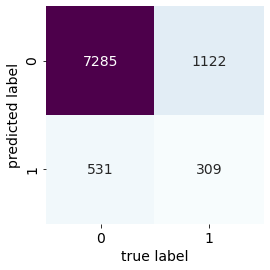

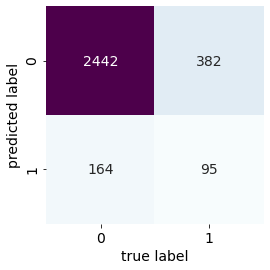

In [179]:
x, y, class_names, feature_names = xy_split(data_frame_os_cat_2)

x_train, x_test, y_train, y_test, classifier = train_test_classifier(x, y, test_size=0.25)
print('--------------------------------------------------------')
print("Report for Training")
y_pred_train = prediction(classifier, x_train)
f1_cm_report(y_train, y_pred_train, class_names=class_names)
print('--------------------------------------------------------')
print("Report for Testing")
y_pred_test = prediction(classifier, x_test)
f1_cm_report(y_test, y_pred_test, class_names=class_names)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.5 .......................................................
[CV] ........................................ alpha=0.5, total=   0.0s
[CV] alpha=0.5 .......................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......................................... alpha=10, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ......................................... alpha=10, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ........................................ alpha=100, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ........................................ alpha=100, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ........................................ alpha=100, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ........................................ alpha=100, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ........................................ alpha=100, total=   0.0s
-------------------------
Best Hyperparameter Setting (by f1 score): Categori

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


(0.3612903225806451, 0.23959328848811412)

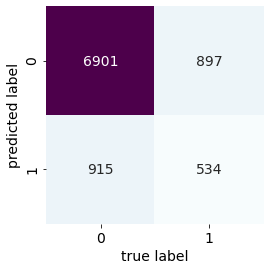

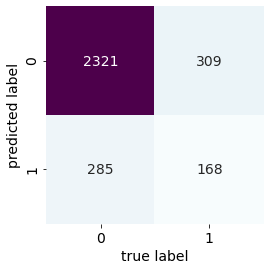

In [180]:
x, y, class_names, feature_names = xy_split(data_frame_os_cat)

x_train, x_test, y_train, y_test, classifier = train_test_classifier(x, y, test_size=0.25)
print('--------------------------------------------------------')
print("Report for Training")
y_pred_train = prediction(classifier, x_train)
f1_cm_report(y_train, y_pred_train, class_names=class_names)
print('--------------------------------------------------------')
print("Report for Testing")
y_pred_test = prediction(classifier, x_test)
f1_cm_report(y_test, y_pred_test, class_names=class_names)

# 6. Mixed Naive Bayes Classifier

As explained earlier, the Mixed Naive Bayes approach is to independently fit a Gaussian NB Classifier and Categorical NB Classifier for the respective numerical and categorical features, and then transform the dataset by setting the class assignment probabilities as new features (this works due to the Naive assumption of independence between features). Following which, a Gaussian NB classifier will be refit on these features. 

The distribution used for the Categorical Naive Bayes Classifier has been explained above.

Meanwhile, for the Gaussian Naive Bayes Classifier, the mean ($\mu$) and variance ($\sigma^2$) for $x$ in each class $k$ is first calculated, then the likelihood $P(x_i|C_k)$ is calculated using the formula:<br>

<center> $P(x_i|C_k) = \large\frac{1}{\sqrt[2]{2\pi\sigma^2}}$$e^{\large\frac{(x_i-\mu_k)^2}{2\sigma^2_k}}$ </center>

There are no hyperparameters.

#### Results 

As seen from the much lower f1 scores of the MixedNB model, this model performs significantly poorer as compared to the CategoricalNB method. As such, the CategoricalNB model has been selected to continue further analysis in the following sections. 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.5 .......................................................
[CV] ........................................ alpha=0.5, total=   0.0s
[CV] alpha=0.5 .......................................................
[CV] ........................................ alpha=0.5, total=   0.0s
[CV] alpha=0.5 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.5s finished


(0.06932409012131716, 0.23959328848811412)

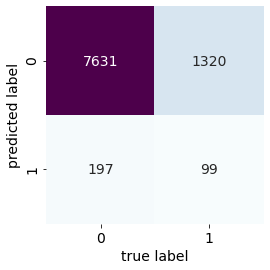

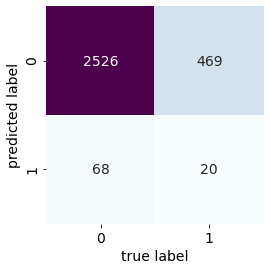

In [175]:
# ----- Prepare data -----
# Select data for modeling

x_g = data_frame_os[['ProductRelated_Duration', 'ProductRelatedAve', 'BounceRates', 'ExitRates', 'SpecialDay']]
x_c = data_frame_os[['Month', 'Region', 'VisitorType', 'Weekend']]
Y = data_frame_os[['Revenue']].values

# Combine all variables into one array
X=np.c_[x_g, x_c]

# Create training and testing samples
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)

# ----- Fit the two models -----
# Now use the Gaussian model for continuous independent variable and 
model_G = GaussianNB()
clf_G = model_G.fit(X_train[:,0:5], Y_train)
# Categorical model for discrete independent variable
param_grid = [{'alpha': [0.1,0.5, 1.0, 5, 10, 100]}]
model_C = CategoricalNB()
grid_search = GridSearchCV(model_C, param_grid, cv=5, verbose=2, scoring = 'f1')
clf_C = grid_search.fit(X_train[:,5:9], Y_train)
model_C = grid_search.best_estimator_
model_C.fit(X_train[:,5:9], Y_train)

# ----- Get probability predictions from each model -----
# On training data
G_train_probas = model_G.predict_proba(X_train[:,0:5])
C_train_probas = model_C.predict_proba(X_train[:,5:9])
# And on testing data
G_test_probas = model_G.predict_proba(X_test[:,0:5])
C_test_probas = model_C.predict_proba(X_test[:,5:9])

# Combine probability prediction for class= 1 from both models into a 2D array
X_new_train = np.c_[(G_train_probas[:,1], C_train_probas[:,1])] # Train
X_new_test = np.c_[(G_test_probas[:,1], C_test_probas[:,1])] # Test

# ----- Fit Gaussian model on the X_new -----
model = GaussianNB()
clf = model.fit(X_new_train, Y_train)

# Predict class labels on a test data
Y_pred_train = clf.predict(X_new_train)
Y_pred_test = clf.predict(X_new_test)

print('--------------------------------------------------------')
print("Report for Training")
y_pred_train = prediction(clf, X_new_train)
f1_cm_report(Y_train, Y_pred_train, class_names=None)
print('--------------------------------------------------------')
print("Report for Testing")
y_pred_test = prediction(clf, X_new_test)
f1_cm_report(Y_test, Y_pred_test, class_names=None)

# 7. Feature Importance

Permutation feature importance is a model inspection technique that can be defined as the decrease in the model score when a single feature value is randomly shuffled. By doing so, this breaks the relationship between the feature and target, and the resulting drop in the model score (this is returned as a value > 0, where values <= 0 indicates the features do not contribute at all) can indicate how dependent the model is on the feature for making predictions. 

Through this, it is possible to highlight the features that contribute to the generalization power of the model. Additionally, comparison of differences between the training and test set could lead to identification of features that may lead to overfitting (in the case where features which are important in the training set are not in the test set). 

This is achieved using the *permutation_importance* function from scikit, where features have been set to shuffle 10 times randomly in this case. F1 is the performance metric (the function uses the estimator's performance metric which has been set earlier).

#### Results

From the results, it seems like all the features (except Month) generally does not contribute much to the predictive power of the model based on the values returned (highest value was 0.015, rest was close to 0). However, it must be noted that this does not imply anything about the intrinsic predictive value of the features. Also, both training and test set share the same important features, hence overfitting is unlikely to be a concern here. 

Feature ranking:
1. Month (0.004109)
2. VisitorType (0.001719)
3. Weekend (0.000865)
4. Region (-0.000173)
5. SpecialDay (-0.003926)
6. ProductRelated_Duration (-0.004921)
7. ProductRelatedAve (-0.006608)
8. BounceRates (-0.008414)
9. ExitRates (-0.008684)


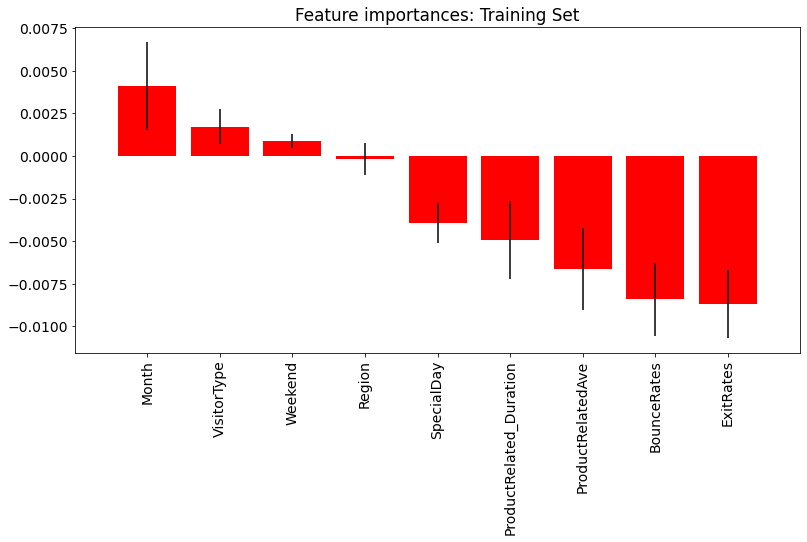

In [459]:
imps = permutation_importance(classifier, x_train, y_train, n_repeats = 10)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(13, 6))
plt.title("Feature importances: Training Set")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), [features[indices[i]] for i in range(9)], rotation='vertical')
plt.xlim([-1, x_train.shape[1]])
plt.show()

Feature ranking:
1. Month (0.015504)
2. VisitorType (0.002465)
3. Region (0.001362)
4. Weekend (-0.002400)
5. SpecialDay (-0.003049)
6. ProductRelated_Duration (-0.004249)
7. BounceRates (-0.006682)
8. ExitRates (-0.007071)
9. ProductRelatedAve (-0.008174)


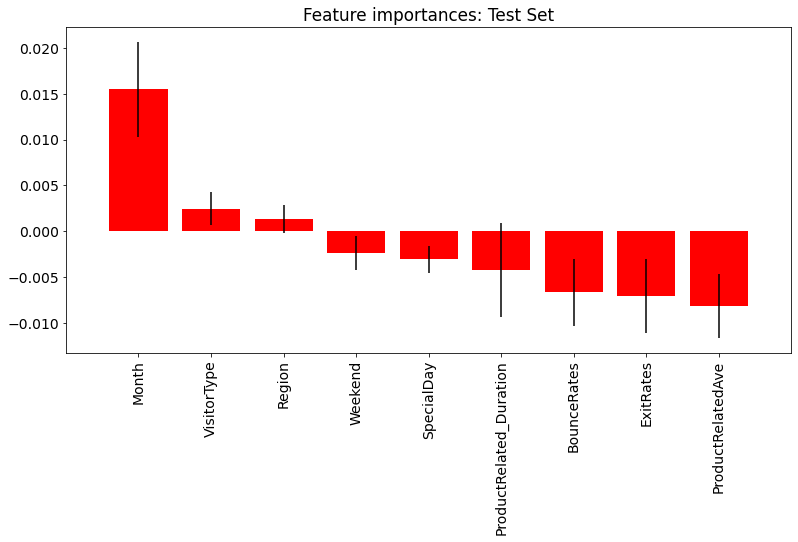

In [460]:
imps = permutation_importance(classifier, x_test, y_test, n_repeats = 10)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(x_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(13, 6))
plt.title("Feature importances: Test Set")
plt.bar(range(x_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_test.shape[1]), [features[indices[i]] for i in range(9)], rotation='vertical')
plt.xlim([-1, x_test.shape[1]])
plt.show()

# 8 PR Curves & Threshold Moving (For imbalanced classification)

#### Precision-Recall Curve 

Precision-Recall (PR) Curves reflect the trade-off between the true positive rate and the positive predictive value across a range of probability thresholds (definitions were stated earlier above). The curve plots precision (y-axis) and the recall (x-axis) across different thresholds. The closer the curve to the top right of the plot, the better the model. The curve is generated using the *precision_recall_curve* function from the module *scikit-learn*, and displayed using the *Matplotlib* module. 

For this dataset, the PR curve is used instead of the Receiver Operator Characteristic (ROC) curve (which plot True positive rate against False positive rate) due to the imbalanced nature of the data, in which we are less concerned at the model's skill in prediction class 'False' correctly, and more concerned with the correct prediction of the minority class. 

A no-skill line has been plotted has well, and illustrates a no-skill classifier that is unable to discriminate between classes and always predict a random or constant class. This is a horizontal line depicting the ratio of the 'True' class in the dataset. 

The AUC score (Area Under Curve) summarizes the integral of the area under the PR curve. Generally, it can be interpreted as summarizizing the skill of a model across various thresholds.

#### Threshold Moving

While the algorithm predicts the probabilities of a class given the sample features, for binary classification problems (as in this case), a threshold must be set such that values >= to the threshold are mapped to one class and the remaining values to the other class. Typically, the threshold used is 0.5. However, as the class data on this dataset is imbalanced, such a threshold could result in poor performance due to the lower probability of occurence of the rarer class. As such, the threshold has been tuned by identifying the threshold which gives the highest model perfomance (F1 score). The identified threshold is also plotted on the PR curve for ease of comprehension. 

#### Results 

As seen, if the threshold is reduced to 0.352, the f score improves from 0.36 to 0.396, improving the performance of the model. 

Counter({0: 2630, 1: 453})


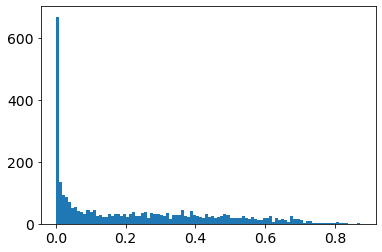

In [181]:
# retrieve just the probabilities for the positive class
y_prob_categorical = classifier.predict_proba(x_test)[:,1]

# summarize the distribution of class labels
print(Counter(y_pred_test))

# create a histogram of the predicted probabilities
pyplot.hist(y_prob_categorical, bins=100)
pyplot.show() # can see that majority of probabilities fall under 0.5

PR AUC: 0.318
Best Threshold=0.352096, F-Score=0.396


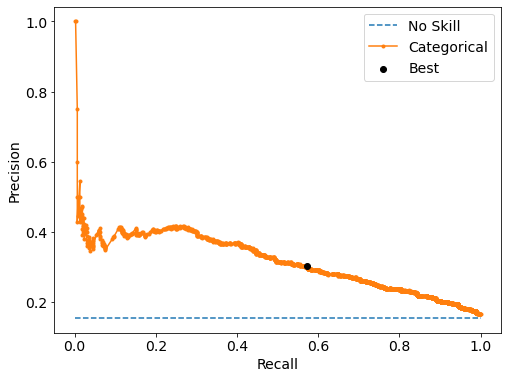

In [114]:
# plot no skill and model precision-recall curves
def plot_pr_curve(y_test, model_probs):
    #obtain precision recall and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, model_probs)
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y_test[y_test==1]) / len(y_test)
    # calculating the AUC score
    auc_score = auc(recall, precision)
    print('PR AUC: %.3f' % auc_score)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    
    plt.figure(figsize=(8, 6))
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot PR curve
    plt.plot(recall, precision, marker='.', label='Categorical', zorder=1)
    # plot optimum threshold
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best', zorder=2)
    # plot axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

plot_pr_curve(y_test, y_prob_categorical)

# 9 Resampling (for Imbalanced Dataset)

Resampling techniques may also be helpful in helping to address the issue of class imbalance. Three methods are tested below, oversampling, undersampling and synthetic minority oversampling. Oversampling adds more copies of the minority class in the training set to make it even with the majority class, while conversely undersampling removes observations of the majority class. The *resampling* module from *Scikit-Learn* has been used to achieve this. 

Meanwhile, synthetic minority oversampling oversampling technique (SMOTE) creates synthetic samples using a nearest neighbors algorithm to generate new and synthetic data. This is done using the *SMOTE* function from the *imblearn* module.

#### Results

As can be seen, all methods performed approximately equally, and returned improved performance of the model, raising the F1 score to 0.38 on the test set. The sampling techniques were particularly effective at reducing the false negatives, and consequently improving the recall scores drastically, but did not manage to improve the false positive scores (and in fact it performed worse than the original model). 

In [187]:
# Separate input features and target
y = data_frame_os_cat.Revenue
y, class_names = pd.factorize(y)
y= pd.DataFrame({'Revenue':y}) 
x = data_frame_os_cat.drop('Revenue', axis=1)

# setting up testing and training sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, random_state=42)

# concatenate our training data back together
X = pd.concat([x_train, y_train], axis=1)

# separate minority and majority classes
not_true = X[X.Revenue==0]
true = X[X.Revenue==1]

# upsample minority
true_upsampled = resample(true,
                          replace=True, # sample with replacement
                          n_samples=len(not_true), # match number in majority class
                          random_state=43) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_true, true_upsampled])

# check new class counts
upsampled.Revenue.value_counts()

1    7828
0    7828
Name: Revenue, dtype: int64

Report for Training Set
F1 Score: 0.73
              precision    recall  f1-score   support

           0       0.76      0.56      0.65      7828
           1       0.65      0.82      0.73      7828

    accuracy                           0.69     15656
   macro avg       0.71      0.69      0.69     15656
weighted avg       0.71      0.69      0.69     15656

Confusion Matrix: 
 [[4386 3442]
 [1384 6444]]
--------------------------------------------------------
Report for Test Set
F1 Score: 0.38
              precision    recall  f1-score   support

           0       0.93      0.57      0.71      2594
           1       0.25      0.77      0.38       489

    accuracy                           0.60      3083
   macro avg       0.59      0.67      0.54      3083
weighted avg       0.82      0.60      0.66      3083

Confusion Matrix: 
 [[1484 1110]
 [ 113  376]]


(0.3807594936708861, 0.23959328848811412)

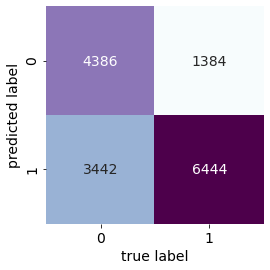

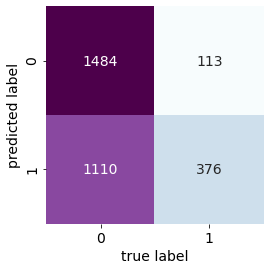

In [188]:
y_train = upsampled.Revenue
x_train = upsampled.drop('Revenue', axis=1)
upsampled = classifier.fit(x_train, y_train)
upsampled_pred_train = upsampled.predict(x_train)
upsampled_pred_test = upsampled.predict(x_test)

print('Report for Training Set')
f1_cm_report(y_train, upsampled_pred_train, class_names=None)
print('--------------------------------------------------------')
print('Report for Test Set')
f1_cm_report(y_test, upsampled_pred_test, class_names = None)

Downsampling

In [189]:
# still using our separated classes true and not_true from above

# downsample majority
not_true_downsampled = resample(not_true,
                                replace = False, # sample without replacement
                                n_samples = len(true), # match minority n
                                random_state = 42) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_true_downsampled, true])

# checking counts
downsampled.Revenue.value_counts()

1    1419
0    1419
Name: Revenue, dtype: int64

Report for Training Set
F1 Score: 0.72
              precision    recall  f1-score   support

           0       0.75      0.56      0.64      1419
           1       0.65      0.81      0.72      1419

    accuracy                           0.69      2838
   macro avg       0.70      0.69      0.68      2838
weighted avg       0.70      0.69      0.68      2838

Confusion Matrix: 
 [[ 796  623]
 [ 264 1155]]
--------------------------------------------------------
Report for Test Set
F1 Score: 0.38
              precision    recall  f1-score   support

           0       0.93      0.57      0.71      2594
           1       0.25      0.77      0.38       489

    accuracy                           0.60      3083
   macro avg       0.59      0.67      0.55      3083
weighted avg       0.82      0.60      0.66      3083

Confusion Matrix: 
 [[1485 1109]
 [ 112  377]]


(0.3817721518987342, 0.23959328848811412)

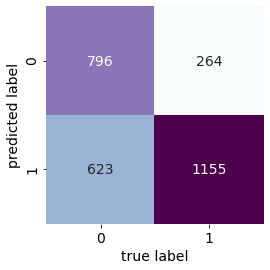

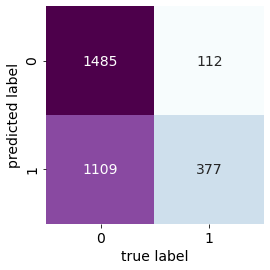

In [190]:
y_train = downsampled.Revenue
x_train = downsampled.drop('Revenue', axis=1)
downsampled = classifier.fit(x_train, y_train)
downsampled_pred_train = downsampled.predict(x_train)
downsampled_pred_test = downsampled.predict(x_test)

print('Report for Training Set')
f1_cm_report(y_train, downsampled_pred_train, class_names=None)
print('--------------------------------------------------------')
print('Report for Test Set')
f1_cm_report(y_test, downsampled_pred_test, class_names=None)

/Users/clement/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Report for Training Set
F1 Score: 0.73
              precision    recall  f1-score   support

           0       0.77      0.57      0.65      7828
           1       0.66      0.83      0.73      7828

    accuracy                           0.70     15656
   macro avg       0.71      0.70      0.69     15656
weighted avg       0.71      0.70      0.69     15656

Confusion Matrix: 
 [[4442 3386]
 [1339 6489]]
--------------------------------------------------------
Report for Test Set
F1 Score: 0.38
              precision    recall  f1-score   support

           0       0.93      0.58      0.71      2594
           1       0.25      0.75      0.38       489

    accuracy                           0.61      3083
   macro avg       0.59      0.67      0.55      3083
weighted avg       0.82      0.61      0.66      3083

Confusion Matrix: 
 [[1502 1092]
 [ 120  369]]


0.3784615384615385

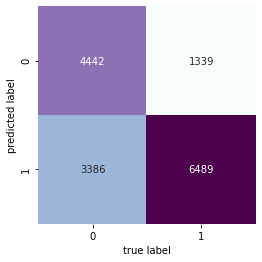

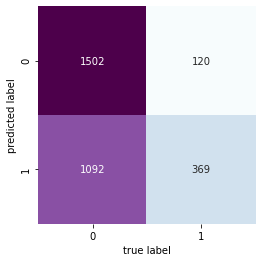

In [23]:
from imblearn.over_sampling import SMOTE

y = data_frame_os_cat.Revenue
y, class_names = pd.factorize(y)
y = pd.DataFrame({'Revenue':y}) 
x = data_frame_os_cat.drop('Revenue', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, random_state=42)

sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)

smote = CategoricalNB(alpha=0.1).fit(X_train, y_train)

smote_pred_train = smote.predict(X_train)
smote_pred_test = smote.predict(X_test)

print('Report for Training Set')
f1_cm_report(y_train, smote_pred_train, class_names=None)
print('--------------------------------------------------------')
print('Report for Test Set')
f1_cm_report(y_test, smote_pred_test, class_names=None)


# Conclusion


# References 